In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pymatreader import read_mat
from skimage.io import imread, imsave
from skimage.transform import resize

/home/ataleckij/Projects/university/MO_4sem/laba4/py3_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ataleckij/Projects/university/MO_4sem/laba4/py3_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ataleckij/Projects/university/MO_4sem/laba4/py3_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("q

In [2]:
# tf.config.gpu.set_per_process_memory_fraction(0.80)

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4*1024)])

# tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
print(tf.config.experimental.list_physical_devices('GPU'), tf.executing_eagerly())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] True


In [3]:
# x = [[2.]]
# m = tf.matmul(x, x)
# print("hello, {}".format(m))
# m

### data reading

In [4]:
def extract_labels(mat_bboxes):
    labels = []
    for bbox in mat_bboxes:
        if type(bbox['label']) is list:
            label = ''.join([str(int(value)) for value in bbox['label']])
        else:
            label = str(int(bbox['label']))
        labels.append(label)
    return labels

def convert_to_csv(set_type):
    mat = read_mat(f'data/{set_type}/digitStruct.mat')
    
    df = pd.DataFrame({
        'img_names': mat['digitStruct']['name'], 
        'labels': extract_labels(mat['digitStruct']['bbox'])
    })
    df.to_csv(f'data/{set_type}.csv', index=False)
    return df

In [5]:
# df_train = convert_to_csv('train')
# df_test = convert_to_csv('test')

In [6]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

7


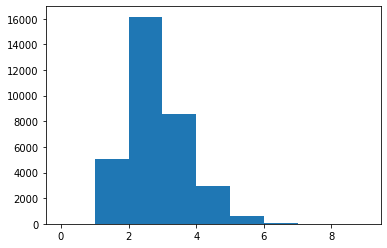

7


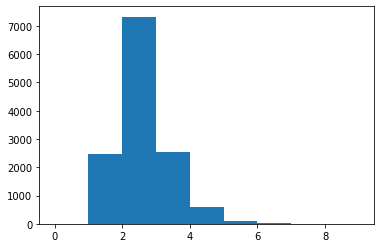

In [7]:
train_lens = df_train['labels'].astype(str).map(lambda s: len(s)).values
plt.hist(train_lens, bins=list(range(10)))
print(train_lens.max())
plt.show()

test_lens = df_test['labels'].astype(str).map(lambda s: len(s)).values
plt.hist(test_lens, bins=list(range(10)))
print(test_lens.max())
plt.show()

In [8]:
def get_images_stats(df, dir_name):
    coefs, widths = [], []
    for img_name in tqdm(df['img_names'].values):
        img = imread(f'data/{dir_name}/{img_name}')
        coefs.append(img.shape[1]/img.shape[0])
        widths.append(img.shape[1])
    return np.asarray(coefs), np.asarray(widths)

coefs, widths = get_images_stats(df_train, 'train')

100%|██████████| 33402/33402 [00:36<00:00, 926.24it/s] 


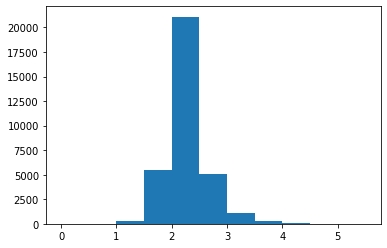

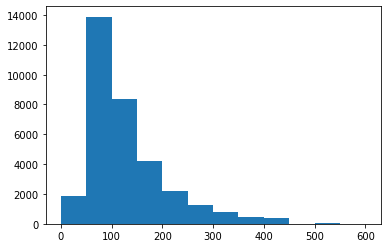

In [9]:
plt.hist(coefs, bins=np.arange(0, 6, 0.5))
plt.show()

plt.hist(widths, bins=np.arange(0, 650, 50))
plt.show()

In [10]:
MAX_NUMBERS = 4#7
IMAGES_HEIGHT, IMAGES_WIDTH = 64, 128#90, 180#

In [11]:
df_train.shape, df_test.shape

((33402, 2), (13068, 2))

In [12]:
df_train = df_train[df_train['labels'].astype(str).map(lambda s: len(s)) <= MAX_NUMBERS]
df_test = df_test[df_test['labels'].astype(str).map(lambda s: len(s)) <= MAX_NUMBERS]
df_train.shape, df_test.shape

((32756, 2), (12961, 2))

### model

In [13]:
def get_model(max_numbers=MAX_NUMBERS, img_shape=(IMAGES_HEIGHT, IMAGES_WIDTH)):
    input_ = x = tf.keras.layers.Input((*img_shape, 3))
    
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPool2D((3, 3))(x)
    
#     x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
#     x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
#     x = tf.keras.layers.MaxPool2D((2, 2))(x)
    
    x = tf.keras.layers.Flatten()(x)
    
#     x = tf.keras.layers.Dropout(0.35)(x)
#     x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.45)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.35)(x)
    
    len_prediction = tf.keras.layers.Dense(128, activation='relu')(x)
    len_prediction = tf.keras.layers.Dense(max_numbers, activation='softmax')(len_prediction)
#     if sparse:
#         len_prediction = tf.keras.backend.argmax(len_prediction, axis=-1) + 1
    len_prediction = tf.keras.backend.expand_dims(len_prediction, axis=-1)
        
    numbers_predictions = []
    for _ in range(max_numbers):
        ni_pred = tf.keras.layers.Dense(128, activation='relu')(x)
        ni_pred = tf.keras.layers.Dense(10, activation='softmax')(ni_pred)
#         if sparse:
#             ni_pred = tf.keras.backend.argmax(ni_pred, axis=-1)
        ni_pred = tf.keras.backend.expand_dims(ni_pred, axis=1)
        numbers_predictions.append(ni_pred)

    output = tf.keras.layers.concatenate([*numbers_predictions], axis=1)
    output = tf.keras.layers.concatenate([len_prediction, output], axis=-1)
    return tf.keras.models.Model(input_, output)

In [14]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 128, 32)  9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
x1 = model.predict(np.random.randint(0, 255, (5, IMAGES_HEIGHT, IMAGES_WIDTH, 3)))
x2 = x1.copy()
x1.shape

(5, 4, 11)

In [16]:
# mobilenetv2_model = tf.keras.applications.MobileNetV2(include_top=False, weights=None, pooling=None)
# mobilenetv2_model.summary()

In [17]:
def get_mobile_model(max_numbers=MAX_NUMBERS, img_shape=(IMAGES_HEIGHT, IMAGES_WIDTH)):
    input_ = x = tf.keras.layers.Input((*img_shape, 3))
    
    mobilenetv2_convbase = tf.keras.applications.MobileNetV2(
        include_top=False, weights=None, pooling=None
    )
    x = mobilenetv2_convbase(x)
    x = tf.keras.layers.MaxPool2D((2, 3))(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.35)(x)
    
    len_prediction = tf.keras.layers.Dense(64, activation='relu')(x)
    len_prediction = tf.keras.layers.Dense(max_numbers, activation='softmax')(len_prediction)
#     if sparse:
#         len_prediction = tf.keras.backend.argmax(len_prediction, axis=-1) + 1
    len_prediction = tf.keras.backend.expand_dims(len_prediction, axis=-1)
        
    numbers_predictions = []
    for _ in range(max_numbers):
        ni_pred = tf.keras.layers.Dense(64, activation='relu')(x)
        ni_pred = tf.keras.layers.Dense(10, activation='softmax')(ni_pred)
#         if sparse:
#             ni_pred = tf.keras.backend.argmax(ni_pred, axis=-1)
        ni_pred = tf.keras.backend.expand_dims(ni_pred, axis=1)
        numbers_predictions.append(ni_pred)

    output = tf.keras.layers.concatenate([*numbers_predictions], axis=1)
    output = tf.keras.layers.concatenate([len_prediction, output], axis=-1)
    return tf.keras.models.Model(input_, output)

In [18]:
mobilenetv2_model = get_mobile_model()
mobilenetv2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 128, 3)] 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_None (Model)   multiple             2257984     input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 1, 1, 1280)   0           mobilenetv2_1.00_None[1][0]      
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1280)         0           max_pooling2d_3[0][0]            
____________________________________________________________________________________________

### Data Preprocess

In [19]:
def encode_label(label, max_numbers=MAX_NUMBERS):
    len_ = len(label)
    len_encoding = np.zeros(max_numbers)
    len_encoding[len_ - 1] = 1
    len_encoding = len_encoding[:, np.newaxis]
    
    numbers_encoding = np.zeros((max_numbers, 10))
    numbers_encoding[np.arange(len_), np.asarray(list(label)).astype(int)] = 1
    return np.hstack((len_encoding, numbers_encoding))

In [20]:
# def get_generator(df, dir_name, batch_size, shuffle=True):
#     while True:
#         if shuffle:
#             df = df.sample(frac=1).reset_index(drop=True)
#         images, labels = [], []
#         for i, (img_name, label) in enumerate(df[['img_names', 'labels']].values):
#             img = imread(f'data/{dir_name}/{img_name}')
#             if 1.8 < img.shape[1] / img.shape[0] < 2.2:
#                 img_padded = img
#             elif img.shape[1] / img.shape[0] <= 1.8:
#                 img_padded = pad_image(img, (img.shape[0], img.shape[0]*2))
#             elif img.shape[1] / img.shape[0] >= 2.2:
#                 img_padded = pad_image(img, (img.shape[1]//2, img.shape[1]))
#             else:
#                 raise NotImplementedError()
#             img_padded_resized= resize(img_padded, (IMAGES_HEIGHT, IMAGES_WIDTH))# devide 255
# #             print(img_padded_resized.max())
#             images.append(img_padded_resized)
#             labels.append(encode_label(str(label)))
#             if ((i + 1) % 16 == 0 and i != 0) or (i + 1) == df.shape[0] - 1:
#                 yield np.asarray(images), np.asarray(labels)
#                 images, labels = [], []

In [21]:
def pad_image(img, new_shape):
    pad_img = np.zeros((*new_shape, 3))
    pad_img[:img.shape[0], :img.shape[1]] = img
    return pad_img.astype(np.uint8)


def unify_data_dir(df, dir_name, new_dir_name):
    if not os.path.isdir(f'data/{new_dir_name}'):
        os.mkdir(f'data/{new_dir_name}')
    for img_name, label in tqdm(df[['img_names', 'labels']].values):
        img = imread(f'data/{dir_name}/{img_name}')
        top_coeg, bot_coef = 2.2, 1.8
        if bot_coef < img.shape[1] / img.shape[0] < top_coeg:
            img_padded = img
        elif img.shape[1] / img.shape[0] <= bot_coef:
            img_padded = pad_image(img, (img.shape[0], img.shape[0]*2))
        elif img.shape[1] / img.shape[0] >= top_coeg:
            img_padded = pad_image(img, (img.shape[1]//2, img.shape[1]))
        else:
            raise NotImplementedError()
        img_padded_resized = resize(img_padded, (IMAGES_HEIGHT, IMAGES_WIDTH))
        if not os.path.isdir(f'data/{new_dir_name}/{label}'):
            os.mkdir(f'data/{new_dir_name}/{label}')
        img_padded_resized *= 255
        img_padded_resized[img_padded_resized > 255] = 255
        imsave(f'data/{new_dir_name}/{label}/{img_name}', img_padded_resized.astype(np.uint8))

In [22]:
# unify_data_dir(df_train, 'train', 'train_unified')
# unify_data_dir(df_test, 'test', 'test_unified')

In [23]:
def get_gen(dir_, gen_options, batch_size, max_numbers, target_shape):
    generator_creator = tf.keras.preprocessing.image.ImageDataGenerator(**gen_options)
    generator = generator_creator.flow_from_directory(
        dir_,
        target_size=target_shape,
        batch_size=batch_size,
        class_mode='sparse'
    )
    labels_names = np.asarray(sorted(os.listdir(dir_)))
    while True:
        images, labels_indexes = next(generator)
        encoded_labels = np.vstack(
            list(map(encode_label, labels_names[labels_indexes.astype(int)]))
        ).reshape(images.shape[0], max_numbers, 11)
        yield images, encoded_labels#, labels

In [24]:
np.vstack(
    list(map(encode_label, ['195', '423']))
).reshape(2, 4, 11)

array([[[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [25]:
gen_options = dict(
    rescale=1/255,
    rotation_range=0.05, 
    zoom_range=0.025,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    fill_mode="nearest"
)

train_gen = get_gen(
    'data/train_unified', gen_options, 
    batch_size=32, max_numbers=MAX_NUMBERS,
    target_shape=(IMAGES_HEIGHT, IMAGES_WIDTH)
)

next(train_gen)[0].shape, next(train_gen)[1].shape

Found 32756 images belonging to 1536 classes.


((32, 64, 128, 3), (32, 4, 11))

In [26]:
img_sample, e_label_sample = next(train_gen)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


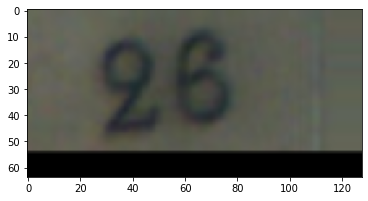

In [27]:
i=np.random.randint(e_label_sample.shape[0])
print(e_label_sample[i])#, label_sample[i])
plt.imshow(img_sample[i])
plt.show()

### fitting

In [28]:
def numbers_loss(y_true, y_pred):
    true_len = y_true[:, :, 0]
    pred_len = y_pred[:, :, 0]
    len_loss = true_len * tf.math.log(pred_len + tf.keras.backend.epsilon())

    true_numbers = y_true[:, :, 1:]
    pred_numbers = y_pred[:, :, 1:]
    numbers_loss = true_numbers * tf.math.log(pred_numbers + tf.keras.backend.epsilon())
    
    return tf.concat((-0.8 * tf.expand_dims(len_loss, axis=-1), 
                      -1.2 * numbers_loss), axis=-1)

In [29]:
def get_len_mask(len_, max_numbers=MAX_NUMBERS):
    return tf.cast(tf.range(MAX_NUMBERS) < len_, tf.int32)

def numbers_acc(y_true, y_pred, weights=[0.3, 0.7]):
    true_len = y_true[:, :, 0]
    pred_len = y_pred[:, :, 0]
    sparse_true_len = tf.argmax(true_len, axis=-1) + 1  # +1 because of length
    len_acc = tf.cast(tf.equal(sparse_true_len, tf.argmax(pred_len, axis=-1) + 1), tf.float32)

    true_numbers = y_true[:, :, 1:]
    pred_numbers = y_pred[:, :, 1:]
    numbers_acc = tf.cast(tf.equal(tf.argmax(true_numbers, axis=-1), 
                                   tf.argmax(pred_numbers, axis=-1)), tf.float32)
    len_mask = tf.map_fn(get_len_mask, tf.cast(sparse_true_len, tf.int32))
    numbers_acc = tf.boolean_mask(numbers_acc, len_mask)
    
    return weights[0] * tf.reduce_mean(len_acc) + weights[1] * tf.reduce_mean(numbers_acc)

In [30]:
numbers_acc(encode_label('211')[np.newaxis, :, :], 
            encode_label('2110')[np.newaxis, :, :])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<tf.Tensor: id=10544, shape=(), dtype=float32, numpy=0.7>

In [31]:
EPOCHS = 100
BATCH_SIZE = 64
VAL_BATCH_SIZE = 16

gen_options = dict(
    rescale=1/255,
    rotation_range=0.05,
    zoom_range=0.035,
    width_shift_range=0.25, 
    height_shift_range=0.25, 
    fill_mode="constant",
    cval=0
)

val_gen_options = dict(
    rescale=1/255,
)

mobilenetv2_model.compile(loss=numbers_loss, optimizer='adam', metrics=[numbers_acc])

mobilenetv2_model.fit_generator(
    get_gen(
        'data/train_unified', gen_options, 
        batch_size=BATCH_SIZE, max_numbers=MAX_NUMBERS,
        target_shape=(IMAGES_HEIGHT, IMAGES_WIDTH)
    ),
    steps_per_epoch=df_train.shape[0] // BATCH_SIZE,
    validation_data=get_gen(
        'data/test_unified', val_gen_options, 
        batch_size=VAL_BATCH_SIZE, max_numbers=MAX_NUMBERS,
        target_shape=(IMAGES_HEIGHT, IMAGES_WIDTH)
    ),
    validation_steps=df_test.shape[0] // VAL_BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/100
Found 32756 images belonging to 1536 classes.
511/511 [==============================] - 106s 207ms/step - loss: 0.1559 - numbers_acc: 0.3193 - val_loss: 0.1418 - val_numbers_acc: 0.3647
Epoch 2/100
511/511 [==============================] - 78s 153ms/step - loss: 0.1513 - numbers_acc: 0.3315 - val_loss: 0.1381 - val_numbers_acc: 0.3640
Epoch 3/100
511/511 [==============================] - 72s 140ms/step - loss: 0.1496 - numbers_acc: 0.3371 - val_loss: 0.1380 - val_numbers_acc: 0.3642
Epoch 4/100
511/511 [==============================] - 71s 140ms/step - loss: 0.1481 - numbers_acc: 0.3473 - val_loss: 0.1385 - val_numbers_acc: 0.3641
Epoch 5/100
511/511 [==============================] - 72s 142ms/step - loss: 0.1464 - numbers_acc: 0.3581 - val_loss: 0.1388 - val_numbers_acc: 0.3645
Epoch 6/100
511/511 [==============================] - 72s 141ms/step - loss: 0.1438 - numbers_acc: 0.3643 - val_loss: 0.1397 - val_numbers_acc: 0.3646
Epoch 7/100
511/511 [====================

KeyboardInterrupt: 

1. увеличенный zoom_range
2. fill_mode nearest вместо constant

In [31]:
EPOCHS = 100
BATCH_SIZE = 64
VAL_BATCH_SIZE = 16

gen_options = dict(
    rescale=1/255,
    rotation_range=0.05,
    zoom_range=0.35,
    width_shift_range=0.25, 
    height_shift_range=0.25, 
    fill_mode="nearest"
)

val_gen_options = dict(
    rescale=1/255,
)

model.compile(loss=numbers_loss, optimizer=tf.keras.optimizers.Adam(), metrics=[numbers_acc])

model.fit_generator(
    get_gen(
        'data/train_unified', gen_options, 
        batch_size=BATCH_SIZE, max_numbers=MAX_NUMBERS,
        target_shape=(IMAGES_HEIGHT, IMAGES_WIDTH)
    ),
    steps_per_epoch=df_train.shape[0] // BATCH_SIZE,
    validation_data=get_gen(
        'data/test_unified', val_gen_options, 
        batch_size=VAL_BATCH_SIZE, max_numbers=MAX_NUMBERS,
        target_shape=(IMAGES_HEIGHT, IMAGES_WIDTH)
    ),
    validation_steps=df_test.shape[0] // VAL_BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/100
Found 32756 images belonging to 1536 classes.
511/511 [==============================] - 82s 160ms/step - loss: 0.1519 - numbers_acc: 0.3280 - val_loss: 0.1389 - val_numbers_acc: 0.3592
Epoch 2/100
511/511 [==============================] - 72s 140ms/step - loss: 0.1509 - numbers_acc: 0.3307 - val_loss: 0.1402 - val_numbers_acc: 0.3467
Epoch 3/100
511/511 [==============================] - 70s 137ms/step - loss: 0.1495 - numbers_acc: 0.3353 - val_loss: 0.1381 - val_numbers_acc: 0.3441
Epoch 4/100
511/511 [==============================] - 70s 137ms/step - loss: 0.1472 - numbers_acc: 0.3468 - val_loss: 0.1364 - val_numbers_acc: 0.3615
Epoch 5/100
511/511 [==============================] - 70s 137ms/step - loss: 0.1424 - numbers_acc: 0.3760 - val_loss: 0.1346 - val_numbers_acc: 0.3559
Epoch 6/100
511/511 [==============================] - 71s 138ms/step - loss: 0.1340 - numbers_acc: 0.4128 - val_loss: 0.1204 - val_numbers_acc: 0.4343
Epoch 7/100
511/511 [=====================

511/511 [==============================] - 69s 136ms/step - loss: 0.0566 - numbers_acc: 0.7675 - val_loss: 0.0588 - val_numbers_acc: 0.7366
Epoch 54/100
511/511 [==============================] - 71s 138ms/step - loss: 0.0566 - numbers_acc: 0.7663 - val_loss: 0.0600 - val_numbers_acc: 0.7275
Epoch 55/100
141/511 [=======>......................] - ETA: 43s - loss: 0.0550 - numbers_acc: 0.7757

KeyboardInterrupt: 

In [32]:
model.save_weights('data/models/keras/custom_numbers_model_0.73_weights')

In [33]:
sample_img = imread('DigitRecognizeJava/app/src/main/res/drawable/house_numbers_sample.png')
prediction = model.predict(sample_img[np.newaxis, :, :, :]/255)[0]
prediction[:, 1:].argmax(axis=1)

array([1, 1, 5, 5])

In [34]:
EPOCHS = 100
BATCH_SIZE = 64
VAL_BATCH_SIZE = 16

gen_options = dict(
    rescale=1/255,
    rotation_range=0.05,
    zoom_range=0.035,
    width_shift_range=0.25, 
    height_shift_range=0.25, 
    fill_mode="constant",
    cval=0
)

val_gen_options = dict(
    rescale=1/255,
)

model.compile(loss=numbers_loss, optimizer=tf.keras.optimizers.Adam(), metrics=[numbers_acc])

model.fit_generator(
    get_gen(
        'data/train_unified', gen_options, 
        batch_size=BATCH_SIZE, max_numbers=MAX_NUMBERS,
        target_shape=(IMAGES_HEIGHT, IMAGES_WIDTH)
    ),
#     get_generator(
#         df_train,#.iloc[:int(0.8 * df_train.shape[0])], 
#         'train', 
#         BATCH_SIZE
#     ),
    steps_per_epoch=df_train.shape[0] // BATCH_SIZE,
#     steps_per_epoch=(0.8 * df_train.shape[0]) // BATCH_SIZE,
#     validation_data=get_generator(
#         df_train.iloc[-int(0.2 * df_train.shape[0]):], 
#         'train',
#         VAL_BATCH_SIZE
#     ),
#     validation_steps=(0.2 * df_train.shape[0]) // VAL_BATCH_SIZE,
    validation_data=get_gen(
        'data/test_unified', val_gen_options, 
        batch_size=VAL_BATCH_SIZE, max_numbers=MAX_NUMBERS,
        target_shape=(IMAGES_HEIGHT, IMAGES_WIDTH)
    ),
    validation_steps=df_test.shape[0] // VAL_BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/100
Found 32756 images belonging to 1536 classes.
511/511 [==============================] - 69s 135ms/step - loss: 0.1521 - numbers_acc: 0.3284 - val_loss: 0.1381 - val_numbers_acc: 0.3591
Epoch 2/100
511/511 [==============================] - 66s 128ms/step - loss: 0.1498 - numbers_acc: 0.3357 - val_loss: 0.1367 - val_numbers_acc: 0.3616
Epoch 3/100
511/511 [==============================] - 64s 125ms/step - loss: 0.1430 - numbers_acc: 0.3691 - val_loss: 0.1344 - val_numbers_acc: 0.3711
Epoch 4/100
511/511 [==============================] - 64s 125ms/step - loss: 0.1307 - numbers_acc: 0.4261 - val_loss: 0.1249 - val_numbers_acc: 0.4199
Epoch 5/100
511/511 [==============================] - 64s 125ms/step - loss: 0.1190 - numbers_acc: 0.4828 - val_loss: 0.1153 - val_numbers_acc: 0.4672
Epoch 6/100
511/511 [==============================] - 64s 125ms/step - loss: 0.1092 - numbers_acc: 0.5239 - val_loss: 0.1098 - val_numbers_acc: 0.4980
Epoch 7/100
511/511 [=====================

KeyboardInterrupt: 

In [42]:
model.save_weights('data/models/keras/custom_numbers_model_0.66_weights')

In [56]:
sample_img = imread('DigitRecognizeJava/app/src/main/res/drawable/house_numbers_sample.png')
prediction = model.predict(sample_img[np.newaxis, :, :, :]/255)[0]

In [61]:
prediction[:, 1:].argmax(axis=1)

array([1, 1, 5, 5])

In [52]:
model.get_weights()[-2].shape

(128, 4)

### Tensorflow lite export

In [34]:
def save_model_to_tflite(model, tflite_model_name):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(f'data/models/tflite/{tflite_model_name}', "wb") as f:
        f.write(tflite_model)

In [35]:
# save_model_to_tflite(mobilenetv2_model, 'numbers_MobileNetV2.tflite')
save_model_to_tflite(model, 'numbers_custom_model_v2.tflite')

INFO:tensorflow:Converted 34 variables to const ops.


In [36]:
interpreter = tf.lite.Interpreter(model_path='data/models/tflite/numbers_custom_model_v2.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data
input_shape = input_details[0]['shape']
# input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
input_data = (sample_img[np.newaxis, :, :, :]/255).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index']) 
print(output_data.shape)

(1, 4, 11)


In [37]:
output_data

array([[[1.3441559e-03, 9.3880307e-37, 9.9847728e-01, 1.4656802e-06,
         1.8553094e-04, 6.8031550e-05, 8.5616228e-04, 9.8887002e-05,
         4.2109099e-05, 3.7943248e-06, 2.6669947e-04],
        [7.6334745e-02, 6.6883090e-09, 9.7211570e-01, 4.3830343e-07,
         1.1309209e-04, 2.3529989e-04, 2.7188463e-02, 2.2597256e-04,
         2.1658138e-06, 3.1506397e-06, 1.1572642e-04],
        [9.1341609e-01, 1.2914497e-02, 1.0921239e-01, 3.9353872e-06,
         6.7944378e-03, 6.1008884e-03, 7.6996392e-01, 8.1732005e-02,
         1.9621488e-05, 1.8746548e-03, 1.1383686e-02],
        [8.9049032e-03, 3.7953733e-03, 1.6950811e-03, 9.6878197e-05,
         1.8561602e-02, 6.2060845e-03, 9.3229252e-01, 1.4192558e-02,
         1.7368482e-04, 2.7334117e-03, 2.0252727e-02]]], dtype=float32)

In [38]:
output_data[0][:, 1:].argmax(axis=1)

array([1, 1, 5, 5])